In [5]:
from mobgap.data import LabExampleDataset
example_data = LabExampleDataset()

c:\Users\paulo\Desktop\mobgap\myenv_mobgap\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
single_test = ha_example_data.get_subset(
    cohort="HA", participant_id="002", test="Test5", trial="Trial2"
)
single_test

,cohort,participant_id,time_measure,test,trial
0,HA,002,TimeMeasure1,Test5,Trial2


In [11]:
imu_data = single_test.data["LowerBack"]
imu_data

c:\Users\paulo\Desktop\mobgap\myenv_mobgap\lib\site-packages\mobgap\data\_mobilised_matlab_loader.py:1189: UserWarning: Global caching is a little tricky to get right and our implementation is not yet battle-tested. Please double check that the results are correct and report any issues you find.
  return hybrid_cache(self.memory, 1)(_load_test_data_without_checks)(


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z
time,,,,,,
2020-08-21 10:30:50.479000092+00:00,9.257165,0.031602,-2.604847,-0.1608,0.2119,-0.3052
2020-08-21 10:30:50.489000082+00:00,9.268460,0.017997,-2.594873,-0.2712,-0.0757,-0.4693
2020-08-21 10:30:50.499000072+00:00,9.272030,0.040954,-2.617060,0.1157,-0.0892,-0.2648
2020-08-21 10:30:50.509000063+00:00,9.262215,0.046100,-2.615381,-0.0091,-0.2005,-0.3278
2020-08-21 10:30:50.519000052+00:00,9.267278,0.070575,-2.585830,0.0524,-0.2733,-0.0965
...,...,...,...,...,...,...
2020-08-21 10:30:58.239000082+00:00,9.162277,0.123379,-2.803288,1.1903,0.7700,0.2111
2020-08-21 10:30:58.249000072+00:00,9.146312,0.103306,-2.765232,1.3227,0.9281,0.4836
2020-08-21 10:30:58.259000063+00:00,9.153765,0.093615,-2.779604,0.9306,1.3176,0.1052


In [12]:
single_sensor_data = single_test.data_ss
single_sensor_data

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z
time,,,,,,
2020-08-21 10:30:50.479000092+00:00,9.257165,0.031602,-2.604847,-0.1608,0.2119,-0.3052
2020-08-21 10:30:50.489000082+00:00,9.268460,0.017997,-2.594873,-0.2712,-0.0757,-0.4693
2020-08-21 10:30:50.499000072+00:00,9.272030,0.040954,-2.617060,0.1157,-0.0892,-0.2648
2020-08-21 10:30:50.509000063+00:00,9.262215,0.046100,-2.615381,-0.0091,-0.2005,-0.3278
2020-08-21 10:30:50.519000052+00:00,9.267278,0.070575,-2.585830,0.0524,-0.2733,-0.0965
...,...,...,...,...,...,...
2020-08-21 10:30:58.239000082+00:00,9.162277,0.123379,-2.803288,1.1903,0.7700,0.2111
2020-08-21 10:30:58.249000072+00:00,9.146312,0.103306,-2.765232,1.3227,0.9281,0.4836
2020-08-21 10:30:58.259000063+00:00,9.153765,0.093615,-2.779604,0.9306,1.3176,0.1052


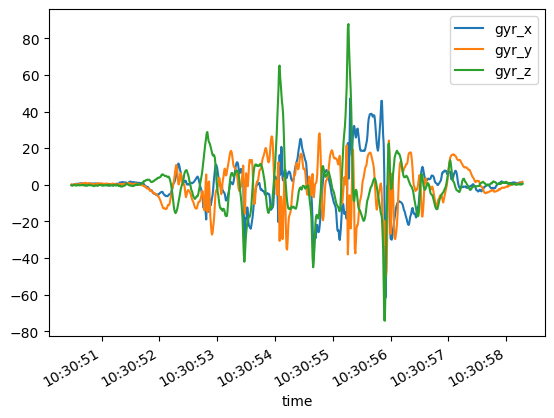

In [15]:
import matplotlib.pyplot as plt

single_sensor_data.filter(like="gyr").plot()
plt.show()

In [16]:
single_test.recording_metadata

{'start_date_time_iso': '2020-08-21T12:30:50.479+02:00',
 'time_zone': 'Europe/Berlin',
 'sampling_rate_hz': 100.0,
 'reference_sampling_rate_hz': None,
 'measurement_condition': 'laboratory',
 'recording_identifier': ('TimeMeasure1', 'Test5', 'Trial2')}

In [17]:
single_test.participant_metadata

{'cohort': 'HA',
 'foot_length_cm': 26.4,
 'handedness': 'right',
 'height_m': 1.75,
 'indip_data_used': 'All',
 'sensor_attachment_su': 'Body-Worn',
 'sensor_height_m': 1.08,
 'sensor_type_su': 'MM+',
 'walking_aid_used': False,
 'weight_kg': 82.0}

In [18]:
example_data_with_reference = LabExampleDataset(reference_system="Stereophoto")
single_trial_with_reference = example_data_with_reference.get_subset(
    cohort="HA", participant_id="002", test="Test5", trial="Trial2"
)
single_trial_with_reference.raw_reference_parameters_

{'lwb': [{'Start': 2.28,
   'End': 5.39,
   'StrideFrequency': 49.36164888953828,
   'Cadence': 98.72329777907656,
   'Duration': 3.11,
   'Length': 4.113706815831932,
   'LengthFeet': 3.990970590722213,
   'WalkingSpeed': 1.3727010349957065,
   'AverageStrideLength': 1.6696087035787461,
   'NumberStrides': 4.0,
   'TerminationReason': 'Pause',
   'Break_Start': array([], dtype=float64),
   'Break_End': array([], dtype=float64),
   'Break_Number': array([], dtype=float64),
   'Break_Duration': array([], dtype=float64),
   'Turning_Flag': 0.0,
   'Turn_Start': array([], dtype=float64),
   'Turn_End': array([], dtype=float64),
   'Turn_Duration': array([], dtype=float64),
   'Turn_Number': array([], dtype=float64),
   'Turn_Angle': array([], dtype=float64),
   'Turn_NumberStrides': array([], dtype=float64),
   'Turn_AngularVelocity': array([], dtype=float64),
   'Turn_PeakAngularVelocity': array([], dtype=float64),
   'Turn_MeanAngularVelocity': array([], dtype=float64),
   'Turn_Length'

In [22]:
ref_paras = single_trial_with_reference.reference_parameters_

ref_paras.wb_list

,start,end,n_strides,duration_s,length_m,avg_walking_speed_mps,avg_cadence_spm,avg_stride_length_m,termination_reason
wb_id,,,,,,,,,
0,227,539,4,3.11,4.113707,1.372701,98.723298,1.669609,Pause


In [23]:
ref_paras.ic_list

ic lr_label
wb_id step_id              
0     0        227     left
      1        295    right
      2        355     left
      3        413    right
      4        471     left
      5        538    right

In [24]:
ref_paras.stride_parameters

start  end  duration_s  length_m  speed_mps  stance_time_s  \
wb_id s_id                                                               
0     0       227  356        1.28  1.613059   1.260202           0.85   
      1       295  414        1.18  1.595190   1.351856           0.74   
      2       355  472        1.16  1.652955   1.424961           0.75   
      3       413  539        1.25  1.817231   1.453785           0.73   

            swing_time_s lr_label  
wb_id s_id                         
0     0             0.43     left  
      1             0.44    right  
      2             0.41     left  
      3             0.52    right

In [25]:
from mobgap.data import (
    get_all_lab_example_data_paths,
    load_mobilised_matlab_format,
)

all_example_data_paths = get_all_lab_example_data_paths()
list(all_example_data_paths.keys())

[('HA', '001'), ('HA', '002'), ('MS', '001')]

In [26]:
example_participant_path = all_example_data_paths[("HA", "002")]
data = load_mobilised_matlab_format(example_participant_path / "data.mat")

In [27]:
test_list = list(data.keys())
test_list

[('TimeMeasure1', 'Test5', 'Trial1'),
 ('TimeMeasure1', 'Test5', 'Trial2'),
 ('TimeMeasure1', 'Test11', 'Trial1')]

In [28]:
test_11_data = data[test_list[2]]
imu_data = test_11_data.imu_data["LowerBack"]
imu_data

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z
time,,,,,,
2020-08-21 10:50:00.388000011+00:00,9.503406,0.014716,-1.251254,0.7467,0.0411,-0.2598
2020-08-21 10:50:00.398000002+00:00,9.505303,-0.003993,-1.255329,0.7143,-0.2051,-0.2739
2020-08-21 10:50:00.407999992+00:00,9.519613,0.010139,-1.287047,0.5649,-0.0735,-0.4197
2020-08-21 10:50:00.417999983+00:00,9.506410,0.024640,-1.293516,0.3432,-0.0719,-0.2773
2020-08-21 10:50:00.427999973+00:00,9.495305,0.053672,-1.238819,0.2914,-0.0606,-0.3616
...,...,...,...,...,...,...
2020-08-21 10:52:40.177999973+00:00,9.558308,0.635739,0.264102,-0.1136,-0.9987,-0.4929
2020-08-21 10:52:40.187999964+00:00,9.585720,0.647438,0.268969,0.4132,-1.2662,-0.5346
2020-08-21 10:52:40.197999954+00:00,9.610060,0.659335,0.249631,0.5845,-1.0722,-0.2816


In [29]:
data_with_reference = load_mobilised_matlab_format(
    example_participant_path / "data.mat", reference_system="INDIP"
)
selected_test = data_with_reference[test_list[2]]

In [30]:
raw_reference_data = selected_test.raw_reference_parameters

In [32]:
ref_sampling_rate_hz = selected_test.metadata["reference_sampling_rate_hz"]
ref_sampling_rate_hz

100.0

In [33]:
from mobgap.data import parse_reference_parameters

data_sampling_rate_hz = selected_test.metadata["sampling_rate_hz"]

ref_paras_functional = parse_reference_parameters(
    raw_reference_data["wb"],
    data_sampling_rate_hz=data_sampling_rate_hz,
    ref_sampling_rate_hz=ref_sampling_rate_hz,
)

In [34]:
ref_paras_functional

ReferenceData(wb_list=       start   end  n_strides  duration_s  length_m  avg_walking_speed_mps  \
wb_id                                                                        
0        485  1131          8        6.45  3.062915               0.557375   
1       1746  3554         16       18.07  3.545885               0.254111   
2       6083  7708         16       16.24  6.231971               0.570759   

       avg_cadence_spm  avg_stride_length_m termination_reason  
wb_id                                                           
0            92.771564             0.747408              Pause  
1            74.218152             0.463619              Pause  
2            84.519972             0.809791              Pause  , ic_list=                 ic lr_label
wb_id step_id               
0     0         485    right
      1         553     left
      2         619    right
      3         692     left
      4         742    right
      5         779     left
      6         862  

In [35]:
from mobgap.data import LabExampleDataset

dataset = LabExampleDataset(reference_system="INDIP")
datapoint = dataset.get_subset(
    cohort="HA", participant_id="001", test="Test11", trial="Trial1"
)
data = datapoint.data_ss
data

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z
time,,,,,,
2020-12-10 13:09:03.815000057+00:00,9.690482,-0.498529,-0.135459,-2.326209,2.967921,-0.916732
2020-12-10 13:09:03.825000048+00:00,9.656917,-0.489721,-0.132339,-1.993893,2.647065,-0.813600
2020-12-10 13:09:03.835000038+00:00,9.611984,-0.476001,-0.097731,-1.535527,2.188699,-0.561499
2020-12-10 13:09:03.845000029+00:00,9.624743,-0.467484,-0.144403,-0.882355,1.879302,-0.355234
2020-12-10 13:09:03.855000019+00:00,9.636681,-0.488557,-0.197406,-0.320856,1.478231,-0.595876
...,...,...,...,...,...,...
2020-12-10 13:11:21.355000019+00:00,9.605895,-0.272558,-0.233749,-2.245995,1.294885,-2.417882
2020-12-10 13:11:21.365000010+00:00,9.606560,-0.333937,-0.245102,-2.727279,0.641713,-2.910626
2020-12-10 13:11:21.375000+00:00,9.577996,-0.333360,-0.271078,-4.549285,-0.160428,-3.701307


In [36]:
ref_data = datapoint.reference_parameters_
ref_data.wb_list

,start,end,n_strides,duration_s,length_m,avg_walking_speed_mps,avg_cadence_spm,avg_stride_length_m,termination_reason
wb_id,,,,,,,,,
0,632,988,5,3.55,3.428989,0.975373,104.069084,1.124391,Pause
1,2864,3325,4,4.60,1.452572,0.411857,81.296475,0.581029,Pause
2,3853,5085,16,12.31,7.044042,0.617801,89.246331,0.838960,Pause
3,7641,8621,12,9.79,4.396574,0.510108,94.370318,0.645176,Pause
4,9451,9932,6,4.80,3.545277,0.755728,88.778698,1.021695,Pause
5,11989,12517,6,5.27,3.514735,0.880632,95.832693,1.021576,Pause


In [37]:
ref_data.ic_list

ic lr_label
wb_id step_id                
0     0          632     left
      1          709    right
      2          763     left
      3          824    right
      4          876     left
...              ...      ...
5     3        12162     left
      4        12220    right
      5        12277     left
      6        12335    right
      7        12516     left

[63 rows x 2 columns]

In [38]:
ref_data_rel = datapoint.reference_parameters_relative_to_wb_
ref_walking_bouts = ref_data_rel.wb_list
ref_walking_bouts

,start,end,n_strides,duration_s,length_m,avg_walking_speed_mps,avg_cadence_spm,avg_stride_length_m,termination_reason
wb_id,,,,,,,,,
0,632,988,5,3.55,3.428989,0.975373,104.069084,1.124391,Pause
1,2864,3325,4,4.60,1.452572,0.411857,81.296475,0.581029,Pause
2,3853,5085,16,12.31,7.044042,0.617801,89.246331,0.838960,Pause
3,7641,8621,12,9.79,4.396574,0.510108,94.370318,0.645176,Pause
4,9451,9932,6,4.80,3.545277,0.755728,88.778698,1.021695,Pause
5,11989,12517,6,5.27,3.514735,0.880632,95.832693,1.021576,Pause


In [39]:
ref_ics_rel = ref_data_rel.ic_list
ref_ics_rel.loc[0]  # First WB

,ic,lr_label
step_id,,
0,0,left
1,77,right
2,131,left
3,192,right
4,244,left
5,301,right
6,355,left


In [40]:
ref_ics_rel.loc[1]  

,ic,lr_label
step_id,,
0,0,right
1,71,left
2,132,right
3,194,left
4,263,right
5,460,left


In [41]:
from mobgap.pipeline import GsIterator

gs_iterator = GsIterator()

# For most use-cases, the default configuration of the :class:`~mobgap.pipeline.GsIterator` should be sufficient.
# This allows you to specify the following results:
gs_iterator.data_type

mobgap.pipeline._gs_iterator.FullPipelinePerGsResult

In [42]:
for (wb, data_per_wb), result in gs_iterator.iterate(data, ref_walking_bouts):
    print("GS/WB id: ", wb.id)
    print(
        "Expected N-samples in wb: ",
        ref_walking_bouts.loc[wb.id].end - ref_walking_bouts.loc[wb.id].start,
    )
    print("N-samples in wb: ", len(data_per_wb))

    # We can use the wb.id to get the reference initial contacts that belong to this GS/WB
    ics_per_wb = ref_ics_rel.loc[wb.id]
    # These could be used in some algorithm.
    # Here we will just store them in the results.
    result.ic_list = ics_per_wb

GS/WB id:  0
Expected N-samples in wb:  356
N-samples in wb:  356
GS/WB id:  1
Expected N-samples in wb:  461
N-samples in wb:  461
GS/WB id:  2
Expected N-samples in wb:  1232
N-samples in wb:  1232
GS/WB id:  3
Expected N-samples in wb:  980
N-samples in wb:  980
GS/WB id:  4
Expected N-samples in wb:  481
N-samples in wb:  481
GS/WB id:  5
Expected N-samples in wb:  528
N-samples in wb:  528


In [43]:
gs_iterator.results_.ic_list

ic lr_label
wb_id step_id                
0     0          632     left
      1          709    right
      2          763     left
      3          824    right
      4          876     left
...              ...      ...
5     3        12162     left
      4        12220    right
      5        12277     left
      6        12335    right
      7        12516     left

[63 rows x 2 columns]